In [1]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import math
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from datetime import datetime

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.learning import get_laplace
from src.utils import (polar_transform, polar_transform_inv, apply_circular_mask, roll_batch, 
                       random_roll, log_biases, log_weights, log_gradients)
from src.visu import (plot_conv_filters, saliency_map, weighted_saliency_map, grad_cam, energy_map, 
                      plot_output_shift, process_until)    

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


2024-02-28 17:10:42.723543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 17:10:42.723639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 17:10:42.723676: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 17:10:42.730790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/project/johannsc/symmetries/RadialBeams/venv/lib/

Num GPUs Available:  1


2024-02-28 17:10:48.784045: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-28 17:10:48.785434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43606 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:04:00.0, compute capability: 8.6


In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()

config = {
    "dataset": 'stanford_dogs',
    "image_size": 100,
    "noise_factor": 0.1,
    "batch_size": 64,
    "n_epochs": 250,
    "n_channels": 3,
    "n_classes": 1000,
    "learning_rate": 1e-4,
}
config |= {
    "radius": config["image_size"]//2 - 5,
}
config |= {
    "len_beam": int(round(config['radius'])),
    "n_beams": int(round(config['radius']*2*np.pi))
}

wandb.init(project="RadialBeams", config=config, group=config['dataset'], name=datetime.now().strftime("%m%d-%H%M"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johschm. Use `wandb login --relogin` to force relogin


In [3]:
train_dataset = tfds.load(config['dataset'], split='train', shuffle_files=False)
test_dataset = tfds.load(config['dataset'], split='test', shuffle_files=False)

def preprocess(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    image = tf.image.resize(image, [config['image_size'], config['image_size']], antialias=True)
    image = apply_circular_mask(image)
    return {
        'image': image,
        'label': example['label'],
        'polar': polar_transform(image, radius=config['radius'])
    }

train_dataset = train_dataset.map(preprocess).batch(config['batch_size'])
test_dataset = test_dataset.map(preprocess).batch(config['batch_size'])

next(iter(train_dataset))['polar'].shape

TensorShape([64, 45, 283, 3])

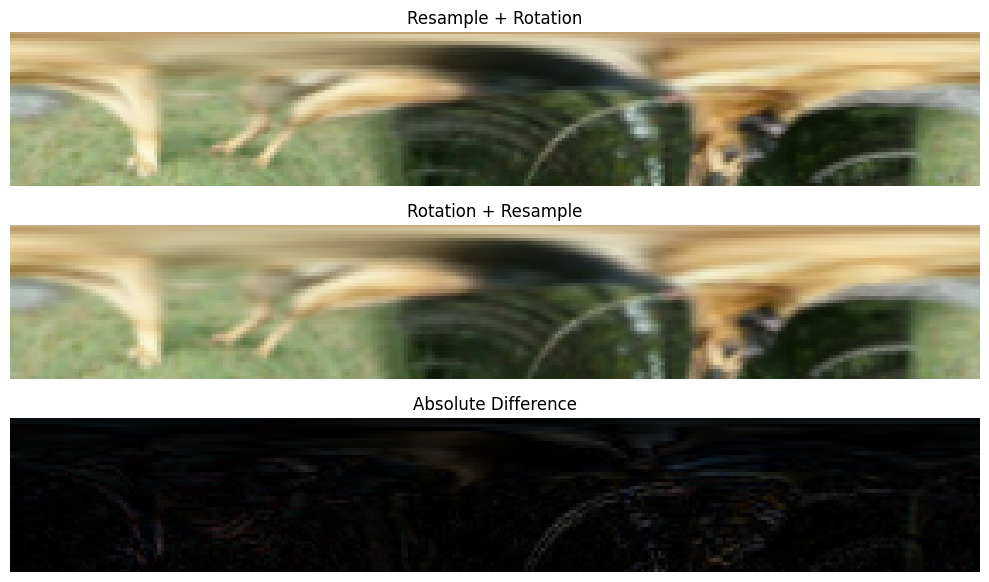

In [4]:
sample = next(iter(test_dataset))
image, polar = sample['image'][1], sample['polar'][1]
fig, axs = plt.subplots(3,1, figsize=(10,6))

polar_a = tf.roll(polar, 50, axis=1)
# polar_a = tfa.image.gaussian_filter2d(polar_a, filter_shape=(3,3), sigma=(1., 1.))
axs[0].imshow(polar_a)
axs[0].set_title('Resample + Rotation')
axs[0].axis('off')

polar_b = polar_transform(tfa.image.rotate(image, angles=-50*np.pi/(config['n_beams']//2), 
                                           interpolation='bilinear'), radius=config['radius'])
axs[1].imshow(polar_b)
axs[1].set_title('Rotation + Resample')
axs[1].axis('off')

axs[2].imshow(np.abs(polar_a - polar_b))
axs[2].set_title('Absolute Difference')
axs[2].axis('off')

plt.tight_layout()

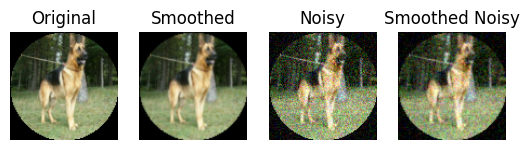

In [5]:
image = sample['image'][1]
noise = tf.random.normal(image.shape)
noise_factor = 0.1
fig, axs = plt.subplots(1,4)
axs[0].imshow(image)
axs[1].imshow(tfa.image.gaussian_filter2d(
    image, filter_shape=(3,3), sigma=0.5))
axs[2].imshow(image + noise_factor * noise)
axs[3].imshow(tfa.image.gaussian_filter2d(
    image + noise_factor * noise, filter_shape=(3,3), sigma=0.5))

axs[0].set_title('Original')
axs[1].set_title('Smoothed')
axs[2].set_title('Noisy')
axs[3].set_title('Smoothed Noisy')

for ax in axs:
    ax.axis('off')

In [6]:
from tensorflow.keras import layers, models

class ResNeXtBlock(tf.keras.Model):
    def __init__(self, n_filters: int, n_groups: int, l2_bias=0.01, l2_weight=0.01, 
                 use_conv_bias=True, use_norm_bias=True, name=None):
        super(ResNeXtBlock, self).__init__(name=name)
        
        self.conv_block = models.Sequential([
            layers.Conv2D(n_filters//2 if n_filters > 1 else n_filters, (1, 1), groups=1,
                          padding='valid', kernel_initializer=tf.keras.initializers.HeNormal(),
                          kernel_regularizer=tf.keras.regularizers.l2(l2_weight),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2(l2=l2_bias),
                          use_bias=use_conv_bias, name="cv0"),
            layers.ELU(),
            layers.LayerNormalization(center=use_norm_bias, name="ln0"),
            
            layers.Conv2D(n_filters, (3, 5), groups=n_groups,
                          padding='valid', kernel_initializer=tf.keras.initializers.HeNormal(),
                          kernel_regularizer=tf.keras.regularizers.l2(l2_weight),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2(l2=l2_bias),
                          use_bias=use_conv_bias, name="cv1"),
            layers.ELU(),
            layers.LayerNormalization(center=use_norm_bias, name="ln1"),
            
            layers.Conv2D(n_filters, (1, 1), groups=1,
                          padding='valid', kernel_initializer=tf.keras.initializers.HeNormal(),
                          kernel_regularizer=tf.keras.regularizers.l2(l2_weight),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2(l2=l2_bias),
                          use_bias=use_conv_bias, name="cv2"),
            layers.ELU(),
            layers.LayerNormalization(center=use_norm_bias, name="ln2"),
        ], name='main')
        self.residual_block = models.Sequential([
            layers.Conv2D(n_filters, (3, 5), groups=1,
                          padding='valid', kernel_initializer=tf.keras.initializers.HeNormal(),
                          kernel_regularizer=tf.keras.regularizers.l2(l2_weight),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2(l2=l2_bias),
                          use_bias=use_conv_bias, name="cv"),
             layers.LayerNormalization(center=use_norm_bias, name="ln")
        ], name='res')

    def call(self, inputs, training=None, **kwargs):
        x = self.conv_block(inputs)
        x_res = self.residual_block(inputs)
        return tf.nn.elu(tf.keras.layers.add([x, x_res]))
    
class PolarRegressor(tf.keras.Model):
    """ Using Cyclic Feature Encoding.
    """
    
    def __init__(self, n_beams, len_beam, n_filters=128, n_channels=3, l2_bias=0.01):
        super().__init__()
        # padding such that kernels of size 3 on the edges use cyclic padded values
        # padding = kernel_size - 1 using "same" padding
        self.receptive_field = 24 # +1
        self.padding = self.receptive_field // 2
        
        # This encodes the polar representation of the image (batch x len_beams x n_beams+padding x channels)
        # down to an energy map of shape (batch x len_beams x n_beams x 1), which preservers translation-equivariance.
        self.latent_polar_map = None
        self.latent_polar_encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams+2*self.padding, n_channels)),
    
            ResNeXtBlock(n_filters=n_filters//4, n_groups=4, l2_bias=1., l2_weight=1., 
                         use_conv_bias=True, use_norm_bias=True, name='rb0'),
            ResNeXtBlock(n_filters=n_filters//2, n_groups=8, l2_bias=0.1, l2_weight=0.1, 
                         use_conv_bias=True, use_norm_bias=True, name='rb1'),
            ResNeXtBlock(n_filters=n_filters, n_groups=16, l2_bias=0.05, l2_weight=0.05,
                         use_conv_bias=True, use_norm_bias=True, name='rb2'),
            ResNeXtBlock(n_filters=n_filters, n_groups=16, l2_bias=0.05, l2_weight=0.05, 
                         use_conv_bias=True, use_norm_bias=True, name='rb3'),
            ResNeXtBlock(n_filters=n_filters, n_groups=16, l2_bias=0.01, l2_weight=0.01, 
                         use_conv_bias=True, use_norm_bias=True, name='rb4'),
            ResNeXtBlock(n_filters=n_filters, n_groups=16, l2_bias=0.01, l2_weight=0.01, 
                         use_conv_bias=True, use_norm_bias=True, name='rb5'),
        ], name='enc0')
        
        self.latent_radial_energy = None
        self.latent_radial_energy_encoder = models.Sequential([
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.LayerNormalization(center=False),
            
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.LayerNormalization(center=False),
        ], name='enc1')
        
        # This maps the transposed energy map (batch x n_beams x len_beams) down to a radial energy over S^1
        # of shape (batch x n_beams), which preservers translation-equivariance.
        self.radial_energy = None
        self.radial_energy_encoder = models.Sequential([
            layers.InputLayer(input_shape=(n_beams, 128)),
            layers.Dense(128),
            layers.Dense(1),
        ], name='enc2')
    
    def cyclic_beam_padding(self, x):
        return tf.concat([x[:, :, x.shape[2]-self.padding:], x, x[:, :, :self.padding]], axis=-2)
    
    def call(self, x):
        # pad the input sequence of radial beams (i.e., the polar representation)
        if self.padding > 0:
            x = self.cyclic_beam_padding(x)
        # compute the energy map of the input
        self.latent_polar_map = self.latent_polar_encoder(x)
        self.latent_radial_energy = self.latent_radial_energy_encoder(self.latent_polar_map)
        # from the energy map, we estimate an energy function over S^1
        # z = tf.transpose(self.energy_map, (0, 2, 1, 3)) # tf.squeeze(self.energy_map, axis=-1)
        self.radial_energy = self.radial_energy_encoder(tf.squeeze(self.latent_radial_energy))
        # we convolve this radial energy by a learned kernel 
        # z = self.angle_encoder(self.radial_energy)
        # normalise the angle vector 
        # return z / tf.norm(z, axis=-1, keepdims=True) 
        # log-probabilities
        return tf.nn.log_softmax(tf.squeeze(self.radial_energy, axis=-1), axis=-1)


model = PolarRegressor(len_beam=config['len_beam'], n_beams=config['n_beams'], n_channels=config['n_channels'])
model.build(input_shape=(config['batch_size'], config['len_beam'], config['n_beams'], config['n_channels']))
model(tf.zeros((config['batch_size'], config['len_beam'], config['n_beams'], config['n_channels'])))
model.summary()

optimizer = tf.keras.optimizers.AdamW(learning_rate=config['learning_rate'])#, weight_decay=0.005)

2024-02-28 17:10:58.370137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-28 17:10:58.393070: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1086a780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 17:10:58.393097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-02-28 17:10:58.952271: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "polar_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc0 (Sequential)           (None, 33, 283, 128)      1035584   
                                                                 
 enc1 (Sequential)           (64, 1, 283, 128)         590592    
                                                                 
 enc2 (Sequential)           (None, 283, 1)            16641     
                                                                 
Total params: 1642817 (6.27 MB)
Trainable params: 1642817 (6.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
label = get_laplace(n_beams=config['n_beams'])
for e in tqdm(range(config['n_epochs'])):
    
    # training loop
    for s, sample in enumerate(train_dataset):
        step = e*len(train_dataset)+s
        image = sample["polar"] + config['noise_factor'] * tf.random.normal(sample["polar"].shape)
        image = (image / tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
        
        with tf.GradientTape() as tape:
            k_distribution = model(image, training=True)
            loss = tf.nn.softmax_cross_entropy_with_logits(logits=k_distribution, labels=label)
            grad = tape.gradient(loss, model.trainable_variables)
        # grad = [(tf.clip_by_value(g, -1., 1.)) for g in grad]
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        wandb.log({"training loss": np.mean(loss.numpy())}, step=step)
            
        # logging
        if s == 1:  
            log_biases(model, wandb.log, step=step)
            log_weights(model, wandb.log, step=step)
            log_gradients(model, grad, wandb.log, step=step)
            # first_layer_filters = model.latent_polar_encoder.layers[0].conv_block.layers[3].get_weights()[0]
            padded_input = model.cyclic_beam_padding(image)
            first_layer_filters = model.get_layer('enc0').get_layer('rb0').get_layer('main').get_layer('cv1').get_weights()[0]
            first_resid_filters = model.get_layer('enc0').get_layer('rb0').get_layer('res').get_layer('cv').get_weights()[0]
            wandb.log({"Conv Filters (first main)": plot_conv_filters(first_layer_filters)})
            wandb.log({"Conv Filters (first res)": plot_conv_filters(first_resid_filters)})
            wandb.log({"Saliency Map": saliency_map(image, model, label)})
            wandb.log({"Weighted Saliency Map": weighted_saliency_map(image, model, label)})
            wandb.log({"GradCAM": grad_cam(image, model)})
            wandb.log({"Energy Map": energy_map(image, model)})
            wandb.log({"Distribution Shift": plot_output_shift(image, model, normalise=True)})
            feature_map = process_until(model.get_layer('enc0').get_layer('rb0').get_layer('main').input,
                model.get_layer('enc0').get_layer('rb0').get_layer('main').get_layer('cv1').output, padded_input)
            wandb.log({"Feature Map (first main)": feature_map})
            feature_map = process_until(model.get_layer('enc0').get_layer('rb0').get_layer('res').input,
                model.get_layer('enc0').get_layer('rb0').get_layer('res').get_layer('cv').output, padded_input)
            wandb.log({"Feature Map (first res)": feature_map})
            wandb.log({"Padded Input": plt.imshow(padded_input[0])})
            plt.close('all')
            
        # equivariance test loop
        # image, k = random_roll(image)
        # test_loss = tf.abs(k + config['n_beams']//2-tf.argmax(model(image), axis=-1))
        # wandb.log({"equivariance test": np.mean(test_loss.numpy())}, step=step)

    # pseudo-equivariant test loop
    test_loss, test_loss_first_rot = [], []
    for s, sample in enumerate(test_dataset):
        image, k = random_roll(sample['polar'])
        test_loss.append(tf.abs(k + config['n_beams']//2-tf.argmax(model(image), axis=-1)).numpy())
        
        # first rotate, then polar sampling to circumvent pixel grid artifacts on which the model might overfit
        image = tfa.image.rotate(sample['image'], angles=-k.numpy()*np.pi/(config['n_beams']//2), interpolation='bilinear')
        image = polar_transform(image, radius=config['radius'])
        test_loss_first_rot.append(tf.abs(k + config['n_beams']//2-tf.argmax(model(image), axis=-1)).numpy())

    wandb.log({"testing loss": np.concatenate(test_loss, axis=0).mean()})
    wandb.log({"testing loss (rotation first)": np.concatenate(test_loss_first_rot, axis=0).mean()})
    # model.save_weights('./model/{0}_{1}.h5'.format(config['dataset'], e))

  0%|                                                                                                                                                                               | 0/250 [00:00<?, ?it/s]2024-02-28 17:11:29.241550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  3%|████▌                                                                                                                                                              | 7/250 [36:51<20:57:10, 310.41s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
from matplotlib.colors import Normalize
def plot_conv_filters(filters):
    """
    Args:
        filters: (kernel x kernel x in_features x out_features)

    Returns:
        figure
    """
    print(np.array(filters).shape)
    in_features, out_features = filters.shape[2:]
    fig, axs = plt.subplots(in_features, out_features, figsize=(out_features, in_features))
    for i in range(in_features):
        for o in range(out_features):
            axs[i, o].imshow(plt.cm.coolwarm(filters[..., i, o]))
            axs[i, o].axis('off')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=Normalize(vmin=filters.min(), vmax=filters.max()))
    plt.colorbar(sm, cax=fig.add_axes([0.92, 0.2, 0.01, 0.6]), orientation='vertical')
    # plt.tight_layout()
    return fig

plot_conv_filters(model.get_layer('enc0').get_layer('rb0').get_layer('main').get_layer('cv1').get_weights()[0])

In [ ]:
fig, axs = plt.subplots(1,4)
for s, sample in enumerate(test_dataset):
    image, label = sample['polar'], sample['label']
    axs[0].imshow(polar_transform_inv(image[0].numpy()))
    image = tf.roll(image, shift=50, axis=2)
    axs[1].imshow(polar_transform_inv(image[0].numpy()))
    k_distribution = model(image)
    k = tf.argmax(k_distribution, axis=-1)
    image_undo = tf.roll(image[0], shift=config['n_beams']//2+k[0], axis=1)
    axs[2].imshow(polar_transform_inv(image_undo.numpy()))
    axs[2].set_title(config['n_beams']//2-k[0])
    image_undo = tf.roll(image[0], shift=config['n_beams']//2-k[0], axis=1)
    axs[3].imshow(polar_transform_inv(image_undo.numpy()))
    plt.show()
    break